In [14]:
%matplotlib inline

import urllib.request
import json
from pprint import pprint
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
import seaborn as sns
import pandas as pd

api_url = "http://api.ggtracker.com/api/v1/matches/"
match_id = "3529593"
extention = ".json"

url = api_url + match_id + extention

with urllib.request.urlopen(url) as response:
    f = json.loads(response.read().decode())
    pprint(f)

In [2]:
import os.path

path="/home/jack/datasets/ggtracker/matches_1k/"

def exists(filename):
    return os.path.isfile(path+filename) 

def save_json(data, filename):
    with open(path+filename, 'w') as outfile:
        json.dump(data, outfile)

def open_json(filename):
    with open(path+filename, 'r') as infile:
        return json.load(infile)

In [3]:
def get_match_data(match_id):
    if exists(path+match_id):
        return open_json(path+match_id)
        
    ext_api_url = "https://gg2-matchblobs-prod.s3.amazonaws.com/"
    url = ext_api_url + match_id 
    try:
        with urllib.request.urlopen(url) as response:
            mdata = json.loads(response.read().decode())
            save_json(mdata, path+match_id)
            return mdata
    except:
        print("Exception")
        return {}

def get_match_units(match_id):
    print(match_id)
    mdata = get_match_data(match_id)
    if not mdata:
        return set([])
    armies = mdata["armies_by_frame"]
    if(len(mdata["armies_by_frame"].keys()) != 2):
        return set([])
    player1, player2 = mdata["armies_by_frame"].keys()
    allunits1_counter = Counter(t[0] for t in armies[player1])
    allunits2_counter = Counter(t[0] for t in armies[player2]) 

    result = set(allunits1_counter) | set(allunits2_counter)
#     print(result)
    return result

In [4]:
def get_units_types(race):
    with open('sc2units.json') as units_file:    
        units = json.load(units_file)
        return Counter(list(units[race]))

In [5]:
def get_units_counts():
    # units = get_units_types()
    units = Counter()
    matches_num = 0

    for i in range(6556976-1000, 6556976):
        match_id = str(i)

        match_units = get_match_units(match_id)
        if match_units:
            matches_num += 1
            units = units + Counter(match_units)
    return units, matches_num

In [6]:
def plot_overall_frequency():
    units, matches_num = get_units_counts()
    plt.figure(figsize=(20, 25), dpi=200)

    us = sorted(units.items(), key=itemgetter(1))
    labels, values = zip(*us)

    values = list(map(lambda x : x/matches_num, values))

    indexes = np.arange(len(labels))
    width = 1

    plt.barh(indexes, values)
    plt.yticks(indexes + width * 0.4, labels)
    plt.show()

In [7]:
def plot_race(race_letter, race_color):
    units = get_units_counts()
    race = get_units_types(race_letter)
    for i in range(30): 
        #dirty hack to get an infinite counter
        race += race
    
    race = units & race 
    race_df = pd.DataFrame.from_dict(dict(race), "index")
    race_df /= race_df.max()
    race_df.sort_values(by=0, inplace=True)
    race_df.plot(kind='barh', figsize=(10, 10), color=race_color, legend=False)

In [8]:
# plot_race("z", "purple")
# plot_race("t", "blue")
# plot_race("p", "gold")

In [9]:
def get_units_dict(race_letter):
    units_names = get_units_types(race_letter).keys()
    return {e : [] for e in units_names}

def nonzero_probe(game):
    if "probe" in game and game["probe"] > 0 \
    or "drone" in game and game["drone"] > 0 \
    or "scv" in game and game["scv"] > 0:
        return True
    else:
        return False

def mins_to_frame(mins):
    return mins*60*16

def howmany_until(frames_list):
    time_list = []
    for t in range(30):
        time_list.append(len([x for x in frames_list if x < mins_to_frame(t)]))
    return time_list

In [10]:
def get_all_units_dict():
    all_units_dict = {**get_units_dict("z"), **get_units_dict("p"), **get_units_dict("t")}
    
    wrong_games = []
    # print(all_units_dict)
    first_times = open_json("first_times.json")
    for e, game in enumerate(first_times):
        if nonzero_probe(game):
            wrong_games.append(e)
        else:
            for k, v in game.items():
                if k not in all_units_dict:
                    print("Unit " + str(k) + " not in units_list")
                else:  
                    all_units_dict[k].append(v)
    return all_units_dict, wrong_games

def get_useduntil_df(race_letter, limitation = 1000):
    all_units_dict, wrong_games = get_all_units_dict()
    print("There are " + str(len(wrong_games)) + " wrong games")
    
    d = {k : howmany_until(sorted(v[:limitation])) for k, v in all_units_dict.items() if k in get_units_dict(race_letter)}
    return pd.DataFrame.from_dict(d, "index").transpose()

There are 287 wrong games
There are 287 wrong games
There are 287 wrong games


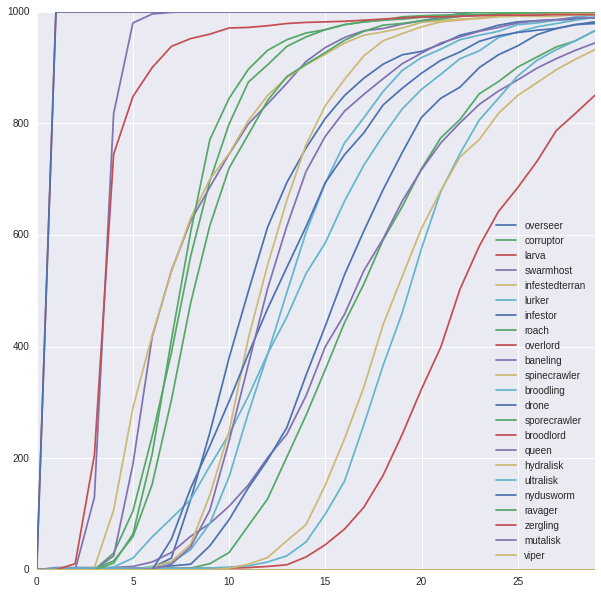

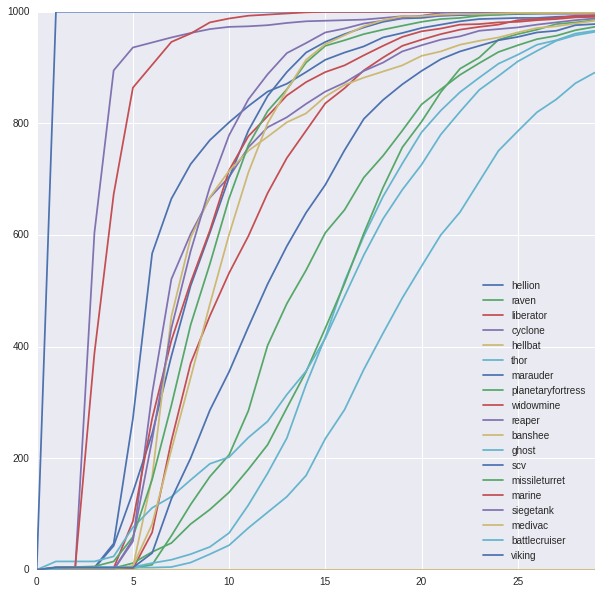

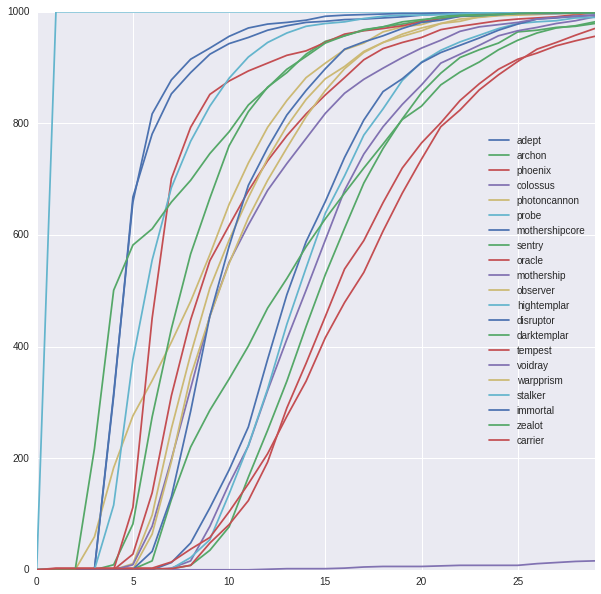

In [15]:
get_useduntil_df("z").plot(figsize=(10,10), dpi=200)
get_useduntil_df("t").plot(figsize=(10,10), dpi=200)
get_useduntil_df("p").plot(figsize=(10,10), dpi=200)
